<a href="https://colab.research.google.com/github/meji9086/TCGA-Data-Analysis/blob/master/TCGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# 패키지 import
import tarfile
import os
import pandas as pd
import numpy as np
import random
import math

!pip install selenium

!apt-get update

!apt install chromium-chromedriver

from selenium import webdriver
from bs4 import BeautifulSoup
import time
from selenium.webdriver.common.keys import Keys
from urllib.request import urlopen
from urllib.parse import quote_plus
from selenium.webdriver.common.keys import Keys
import time
import sys

import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
#from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 985 kB 15.6 MB/s 
     |████████████████████████████████| 139 kB 74.3 MB/s 
     |████████████████████████████████| 358 kB 69.5 MB/s 
     |████████████████████████████████| 55 kB 5.1 MB/s 
     |████████████████████████████████| 4.1 MB 61.9 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.11 which is incompatible.
Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:2 https://cloud

# Data download & file extract

In [11]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [16]:
path = '/content/drive/MyDrive/공모전/genome_data/'
genome_path = '/content/drive/MyDrive/공모전/genome_project/'
genome_name = ['LUAD', 'LUSC']

data = pd.DataFrame()
os.mkdir(path)
def download(x):
  for i in x:
    url = 'http://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/{0}/20160128/gdac.broadinstitute.org_{0}.Merge_rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.Level_3.2016012800.0.0.tar.gz'.format(i)
    driver.get(url)
download(genome_name)

import shutil
for i in genome_name:
  shutil.move('/content/gdac.broadinstitute.org_{0}.Merge_rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.Level_3.2016012800.0.0.tar.gz'.format(i),path)


In [17]:
def data_load(path, cancers):
  # path = '/content/drive/MyDrive/공모전/genome_data/' # 압축 해제 전 데이터 경로
  # genome_path = '/content/drive/MyDrive/공모전/genome_project/' # 압축 해제한 데이터 저장
  genome_path = f'{path}../해제파일/'
  cancer_name = cancers #입력 받는 암 데이터 명

  tar_list = os.listdir(path) #압축 해제 경로
  cancer_df = pd.DataFrame()
  for idx,f in enumerate(tar_list):
    genome = cancer_name[idx]
    ap = tarfile.open(path + f) #압축해제
    ap.extractall(genome_path) # 압축파일 저장
    ap.close 
  
    f_old = os.path.join(genome_path, f.split('.tar')[0]) 
    f_new = os.path.join(genome_path, f'{genome}')
    os.rename(f_old, f_new) # 폴더 명 암 이름으로 요약)
  
data_load('/content/drive/MyDrive/공모전/genome_data/', ['LUAD', 'LUSC'])

# Data labeling & Loading

In [18]:
def data_labeling(path, cancers):
  genome_path = f'{path}../해제파일/'
  cancer_name = cancers
 
  tar_list = os.listdir(path) 
  cancer_df = pd.DataFrame()
  for idx,f in enumerate(tar_list):
    genome = cancer_name[idx]
    txt_list = os.listdir(f'{genome_path}{genome}/')
    file = ''.join([i for i in txt_list if str(genome) in i])

    data = pd.read_csv(f'{genome_path+genome}/{file}', sep='\t', low_memory=False, index_col='Hybridization REF', skiprows=[1])  
    data = data.T
    data['Cancer_info'] = data.index.str.slice(start=13, stop=16)
    data['Cancer_info'] = [f'{genome}_Tumor' if (t == '01A' or t == '02A') else f'{genome}_Normal' for t in list(data['Cancer_info'])]

    cancer_df = pd.concat([cancer_df, data])

  return cancer_df

data = data_labeling('/content/drive/MyDrive/공모전/genome_data/', ['LUAD', 'LUSC'])
data

Hybridization REF,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932,Cancer_info
TCGA-05-4244-01A-01R-1107-07,0.0,10.0113,11.2820,49.5994,848.9397,0.0,345.2308,1.0472,0.0000,0.0,...,292.5212,959.2460,0.6981,1088.0531,2837.9440,871.2802,575.2683,6.6323,0.0000,LUAD_Tumor
TCGA-05-4249-01A-01R-1107-07,0.0,7.1957,12.4436,90.5117,924.0158,0.0,145.2025,1.6098,0.0000,0.0,...,493.5597,1179.3275,20.2833,787.5061,2351.2500,1138.1170,690.2752,179.9738,0.0000,LUAD_Tumor
TCGA-05-4250-01A-01R-1107-07,0.0,7.2453,6.0184,49.5366,1140.6781,0.0,51.7284,0.0000,0.0000,0.0,...,365.4149,843.9028,26.5274,475.1720,5437.4534,1170.5214,532.8691,6.3003,0.0000,LUAD_Tumor
TCGA-05-4382-01A-01R-1206-07,0.0,11.3311,7.5740,82.8303,807.1729,0.0,240.0221,0.4786,0.2393,0.0,...,346.7517,946.6872,64.8514,908.1593,6770.1537,1169.2401,663.8297,35.1777,0.0000,LUAD_Tumor
TCGA-05-4384-01A-01R-1755-07,0.0,3.2254,3.4942,72.5351,562.0037,0.0,274.2822,0.6109,0.0000,0.0,...,563.2254,1320.7086,7.9414,778.8638,3341.4783,1737.3244,723.2743,378.1307,0.0000,LUAD_Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-O2-A52S-01A-11R-A262-07,0.0,19.9503,47.1026,176.7177,1188.3278,0.0,226.8212,1.6556,0.0000,0.0,...,507.4503,1392.7980,126.2417,580.2980,2681.7053,1069.5364,783.1126,5.3808,1.2417,LUSC_Tumor
TCGA-O2-A52V-01A-31R-A262-07,0.0,30.0872,15.2957,188.7215,1248.0303,0.0,147.4945,0.4202,0.0000,0.0,...,366.8453,1326.6099,6.3032,845.8872,6094.3376,663.9353,778.6532,2.1011,0.0000,LUSC_Tumor
TCGA-O2-A52W-01A-11R-A26W-07,0.0,53.6593,33.3907,260.3332,789.3606,0.0,854.3794,0.0000,0.0000,0.0,...,336.9156,2002.6867,101.5583,613.6486,2560.9887,730.2526,761.9559,12.3589,0.0000,LUSC_Tumor
TCGA-O2-A5IB-01A-11R-A27Q-07,0.0,72.5666,42.1832,160.1624,460.8626,0.0,569.2226,1.3312,0.0000,0.0,...,584.1321,2074.5474,150.4260,1155.2183,1185.0373,833.3333,1383.1203,1.0650,0.0000,LUSC_Tumor


# Machine Learning Modeling & Feature Importance

## Data Preprocessing

In [19]:
data_Tumor = data[data['Cancer_info'].str.contains('Tumor')]

data_Tumor['Cancer_info'] = LabelEncoder().fit_transform(data_Tumor['Cancer_info'])
data_Tumor

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hybridization REF,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932,Cancer_info
TCGA-05-4244-01A-01R-1107-07,0.0,10.0113,11.2820,49.5994,848.9397,0.0,345.2308,1.0472,0.0000,0.0,...,292.5212,959.2460,0.6981,1088.0531,2837.9440,871.2802,575.2683,6.6323,0.0000,0
TCGA-05-4249-01A-01R-1107-07,0.0,7.1957,12.4436,90.5117,924.0158,0.0,145.2025,1.6098,0.0000,0.0,...,493.5597,1179.3275,20.2833,787.5061,2351.2500,1138.1170,690.2752,179.9738,0.0000,0
TCGA-05-4250-01A-01R-1107-07,0.0,7.2453,6.0184,49.5366,1140.6781,0.0,51.7284,0.0000,0.0000,0.0,...,365.4149,843.9028,26.5274,475.1720,5437.4534,1170.5214,532.8691,6.3003,0.0000,0
TCGA-05-4382-01A-01R-1206-07,0.0,11.3311,7.5740,82.8303,807.1729,0.0,240.0221,0.4786,0.2393,0.0,...,346.7517,946.6872,64.8514,908.1593,6770.1537,1169.2401,663.8297,35.1777,0.0000,0
TCGA-05-4384-01A-01R-1755-07,0.0,3.2254,3.4942,72.5351,562.0037,0.0,274.2822,0.6109,0.0000,0.0,...,563.2254,1320.7086,7.9414,778.8638,3341.4783,1737.3244,723.2743,378.1307,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-O2-A52S-01A-11R-A262-07,0.0,19.9503,47.1026,176.7177,1188.3278,0.0,226.8212,1.6556,0.0000,0.0,...,507.4503,1392.7980,126.2417,580.2980,2681.7053,1069.5364,783.1126,5.3808,1.2417,1
TCGA-O2-A52V-01A-31R-A262-07,0.0,30.0872,15.2957,188.7215,1248.0303,0.0,147.4945,0.4202,0.0000,0.0,...,366.8453,1326.6099,6.3032,845.8872,6094.3376,663.9353,778.6532,2.1011,0.0000,1
TCGA-O2-A52W-01A-11R-A26W-07,0.0,53.6593,33.3907,260.3332,789.3606,0.0,854.3794,0.0000,0.0000,0.0,...,336.9156,2002.6867,101.5583,613.6486,2560.9887,730.2526,761.9559,12.3589,0.0000,1
TCGA-O2-A5IB-01A-11R-A27Q-07,0.0,72.5666,42.1832,160.1624,460.8626,0.0,569.2226,1.3312,0.0000,0.0,...,584.1321,2074.5474,150.4260,1155.2183,1185.0373,833.3333,1383.1203,1.0650,0.0000,1


## Train/Test split

In [20]:
X_features = data_Tumor.iloc[:, :-1]
y_target = data_Tumor.iloc[:, -1]

X_train, X_test, Y_train, Y_test = train_test_split(X_features, y_target, 
                                                    test_size=0.2, random_state=97, 
                                                    stratify=y_target)

## Find the Best Prameters

In [22]:
XGB_params = { 
    'learning_rate' : [0.1],
    'n_estimators' : [100],
    'max_depth' : [5],
    'min_child_weight' : [0.001],
    'subsample' : [0.8],
    'colsample_bytree' : [0.8],
    'gamma' : [0]
}

XGB_model = XGBClassifier()
grid_XGB = GridSearchCV(XGB_model, param_grid=XGB_params, cv=2, n_jobs=-1)
grid_XGB.fit(X_train, Y_train)
 
 
print('XGBoost 최적의 하이퍼 파라미터:', grid_XGB.best_params_)
print('XGBoost 최적의 예측 정확도: {0:.4f}'.format(grid_XGB.best_score_))

XGBoost 최적의 하이퍼 파라미터: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 0.001, 'n_estimators': 100, 'subsample': 0.8}
XGBoost 최적의 예측 정확도: 0.9604


## Learning with the Best Parameters

In [23]:
XGB_model = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=0.001, subsample=0.8, colsample_bytree=0.8, gamma=0)
XGB_model.fit(X_train, Y_train)

XGBClassifier(colsample_bytree=0.8, max_depth=5, min_child_weight=0.001,
              subsample=0.8)

## Performance Evaluation

In [24]:
# XGBoost accuracy
XGB_test_predict = XGB_model.predict(X_test)
XGB_acc = accuracy_score(XGB_test_predict, Y_test)
print("XGBoost Accuracy : {}".format(XGB_acc))

XGBoost Accuracy : 0.9603960396039604


## Sort 10 Feature Importance

In [25]:
XGB_model = XGBClassifier(random_state=0, max_depth=5, min_samples_leaf=8, min_samples_split=8,n_estimators=200)
XGB_model.fit(X_train, Y_train)
XGB_importances = XGB_model.feature_importances_

n_features = X_train.shape[1]
index = np.arange(n_features)

XGB_model.fit(X_train, Y_train)

importance_sorted_XGB = sorted(XGB_importances, reverse=True)
print('XGBoost Feature Importance ')
for B in importance_sorted_XGB[:10]:
  print(B)

XGBoost Feature Importance 
0.18707429
0.09931523
0.076359645
0.053270575
0.042951245
0.015768185
0.013799449
0.01152406
0.010975922
0.009875743


## Selected Genome

In [26]:
importances_sort_XGB = sorted(XGB_importances, reverse=True)

best_XGB = []
for top in range(len(XGB_importances)):
  if XGB_importances[top] > importances_sort_XGB[10]:
    best_XGB.append(top)  

print('XGBoost selected Feature :')
for d in data_Tumor.columns[best_XGB]:
  print(d)

XGBoost selected Feature :
C9orf152|401546
DSG3|1830
GOLM1|51280
IRF6|3664
KRT5|3852
KRT74|121391
LASS3|204219
S1PR5|53637
SMPDL3B|27293
UNG|7374


## Feature Importance barplot

Text(0.5, 1.0, 'XGBoost')

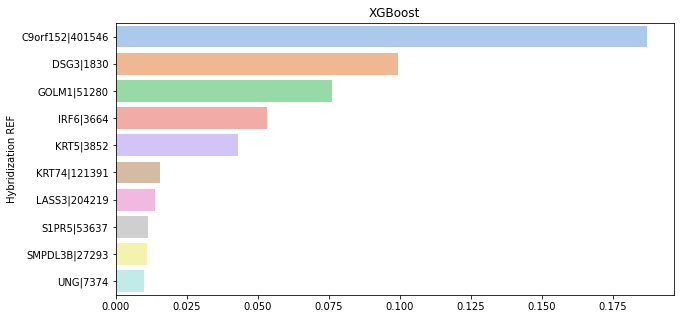

In [37]:
fig = plt.subplots(figsize=(10,5))
sns.set_palette("pastel")
sns.barplot(x=importances_sort_XGB[:10], y=data_Tumor.columns[best_XGB])
plt.title('XGBoost')

## LUAD/LUSC Tumor Gene Difference heatmap

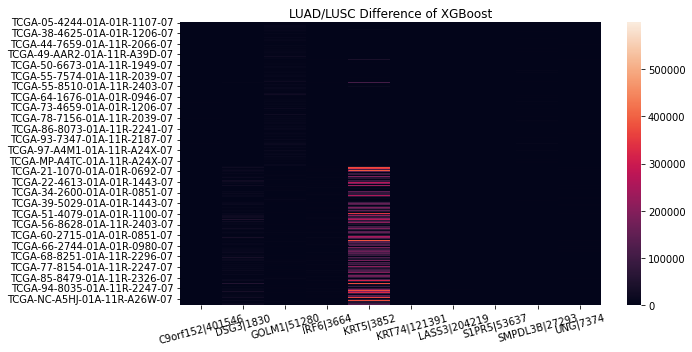

In [36]:
fig = plt.subplots(figsize=(10,5))

final_XGB = data_Tumor[data_Tumor.columns[best_XGB]]

sns.heatmap(final_XGB)
plt.xticks(rotation=15)
plt.xlabel('')
plt.title('LUAD/LUSC Difference of XGBoost')

plt.tight_layout()
plt.show()